<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Катаев Максим Вячеславович

**Забавный факт о себе:** Я не матерюсь вслух, даже когда нахожусь один. Звучит неправдоподобно и забавно, хотя на самом деле это вывело мое общение с людьми на абсолютно другой уровень)

-----
-----

Summary этого ноутбука: всё работает, даже удалось успеть сделать последнее бонусное задание. Если я правильно посчитал, в сумме здесь 3.2 балла. Ссылка на wandb: [ссылка](https://wandb.ai/maxim-kataev-2002/lightning_logs?workspace=user-maxim-kataev-2002).

-----
-----

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

url = "https://drive.google.com/drive/folders/1Mog0vUsRAqC1U1ssxY0B7Pfb2eYy7rb7?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [3]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [4]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [5]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-5-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [6]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [7]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [8]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [9]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [10]:
df_ria.target_tags.values[:3]

array([list([1298, 418, 472]), list([1351, 1169, 472]), list([11])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [11]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [13]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [14]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [15]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [16]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [17]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [18]:
df_vk['title_clean'] = df_vk.title.apply(normalise_text)

word_cnt_vk = Counter(word_tokenize(' '.join(df_vk.title_clean.values)))
len(word_cnt_vk)

32248

In [19]:
df_vk['snippet'] = df_vk['snippet'].fillna('#UNK#')
df_ria['snippet'] = df_ria['snippet'].fillna('#UNK#')

df_vk['snippet_clean'] = df_vk.snippet.apply(normalise_text)
df_ria['snippet_clean'] = df_ria.snippet.apply(normalise_text)

df_vk['snippet_clean'] = df_vk['snippet_clean'].fillna('#UNK#')
df_ria['snippet_clean'] = df_ria['snippet_clean'].fillna('#UNK#')

df_vk['snippet_clean'] = df_vk['snippet_clean'].replace('unk', '#UNK#')
df_ria['snippet_clean'] = df_ria['snippet_clean'].replace('unk', '#UNK#')

df_vk = df_vk.fillna('#UNK#')
df_ria = df_ria.fillna('#UNK#')

In [20]:
df_vk.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,#UNK#,в днр заявили о задержании диверсантов причаст...,#UNK#
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,#UNK#,житель урала заминировал тц изза снятия сотов...,#UNK#
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,#UNK#,в черном море нашли потерянный флот гитлера,#UNK#
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,#UNK#,в сша освободили задержанную российскую актрис...,#UNK#
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,#UNK#,толкнувший скабееву депутат рады заявил о гроз...,#UNK#


In [22]:
df_ria.head()

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[337, 434, 187]",нетаньяху не собирается в отставку в случае пр...,премьерминистр израиля биньямин нетаньяху не н...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[495, 623, 187]",макрон в новогоднем обращении затронул тему ре...,результат реформ не может быть мгновенным заяв...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",#UNK#,теннис,79.0,[395],пятая ракетка мира дель потро пропустит открыт...,аргентинский теннисист хуан мартин дель потро ...
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[926, 187]",сми кевину спейси не разрешили отсутствовать н...,суд в американском штате массачусетс отверг хо...
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",#UNK#,"нхл,хоккей",89.0,"[733, 1250]",зимняя классика нхл в 2020 году пройдет в далл...,зимняя классика матч регулярного чемпионата н...


## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [20]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [21]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [22]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

In [23]:
len(df)

200309

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [24]:
df_test = df_ria[(df_ria['date'] >= '2018-12-01') & (df_ria['date'] <= '2018-12-31')]
df_val = df_ria[(df_ria['date'] >= '2018-10-01') & (df_ria['date'] <= '2018-11-30')]
df_train = df_ria[(df_ria['date'] < '2018-10-01')]

In [25]:
len(df_test) + len(df_val) + len(df_train) == len(df_ria)

True

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [26]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1281, 160]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[886, 472]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[878, 278]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1380]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[273, 472]"


Напишем датасет для поставки данных в нейросеть.


In [27]:
!pip3 install pytorch_lightning

In [28]:
!pip3 install wandb

In [29]:
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

wandb: Currently logged in as: maxim-kataev-2002. Use `wandb login --relogin` to force relogin


True

In [30]:
wandb_logger = WandbLogger(log_model='all')

-----
-----

Далее идет базовая модель, в ней пока нет сниппетов.

-----
-----

In [31]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return (self.X_title[idx, :], self.y[idx])


__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [31]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [32]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [33]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [35]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [39]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: maxim-kataev-2002. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

-----
-----

Далее идет модель со сниппетами, но она окажется хуже. Ссылка на wandb: [ссылка](https://wandb.ai/maxim-kataev-2002/lightning_logs?workspace=user-maxim-kataev-2002)

-----
-----

In [32]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)
       if snippet is not None and max_snippet_len is not None:
        self.X_snippet = self.create_text(snippet, max_snippet_len)
       else:
        self.X_snippet = None

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if (self.X_snippet is not None):
          return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])
        return (self.X_title[idx, :], self.y[idx])

In [33]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20
MAX_SNIPPET_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_SNIPPET_LEN)
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, MAX_SNIPPET_LEN)
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, MAX_SNIPPET_LEN)

In [34]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
from torch import nn
import torch.nn.functional as F

class NewSnippetClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding_title = nn.Embedding(vocab_size, embedding_dim)
        self.embedded_snippet = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        embedded_title = self.embedding_title(title.long())
        embedded_snippet = self.embedded_snippet(snippet.long())
        avg_title = embedded_title.mean(dim=1)
        avg_snippet = embedded_snippet.mean(dim=1)
        concatenated = torch.cat((avg_title, avg_snippet), dim=1)

        output = self.fc1(concatenated)
        return output

In [36]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [37]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_snippet1 = NewSnippetClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_snippet1, LR, criterion)

trainer = pl.Trainer(accelerator="cpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | NewSnippetClassifier | 7.0 M 
1 | criterion | CrossEntropyLoss     | 0     
---------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [38]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [40]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [41]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9954237341880798
Precision: 0.28525426983833313
Recall: 0.7653568983078003


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983235597610474
Precision: 0.5192693471908569
Recall: 0.6190405488014221


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983208775520325
Precision: 0.004975541960448027
Recall: 0.004486594814807177


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [41]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, target in dataloader:
        logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

-----
-----

Для модели со сниппетами:

-----
-----

In [39]:
def get_predict_snippet(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, snippet, target in dataloader:
        logit = model(title, snippet).to(device)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ для нас важнее метрика Precision: мы хотим максимизировать точность прогноза и для нас в целом неважно, что модель хорошо умеет пропускать неподходящие классы (об этом метрика Recall).

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [40]:
def optimal_precision(pred_prob, target):
  precision_dict = dict()
  possible_list = [x * 0.01 for x in range(0, 100)]
  for i in possible_list:
    THRSLD = i
    y_pred = 1*(pred_prob > THRSLD)

    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    new_precision = (num/(denum + 1e-5)).mean().item()
    precision_dict[i] = new_precision
  top_THRSLD = max(precision_dict, key=precision_dict.get)
  return [top_THRSLD, f"Precision: {precision_dict[top_THRSLD]}"]

In [44]:
a = get_predict(model_baseline, val_dataset)

In [45]:
optimal_precision(a[0], a[1])
# [0.13, 'Precision: 0.7247886061668396'] for model_baseline

[0.12, 'Precision: 0.726818859577179']

In [41]:
a_snippet = get_predict_snippet(model_snippet1, val_dataset)

In [42]:
optimal_precision(a_snippet[0], a_snippet[1])
# [0.14, 'Precision: 0.7402571439743042'] for model_snippet1

[0.14, 'Precision: 0.7402571439743042']

-----
-----

Модель со сниппетами немного лучше, впрочем, она склонна к переобучению, поэтому в дальнейшем будем использовать базовую модель.

-----
-----

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

-----
-----

Далее будет видно, что precision снизится примерно на 0.17, но это вполне ожидаемо.

-----
-----

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1395, 1031]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1131, 425]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1543, 961]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[731]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[980, 425]"


In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20
MAX_SNIPPET_LEN = 300

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_SNIPPET_LEN)

In [ ]:
get_predict(model_baseline, oob_dataset)

(tensor([[1.1714e-04, 1.7828e-05, 7.4392e-05,  ..., 9.2048e-05, 3.0681e-07,
          3.0946e-03],
         [2.4384e-06, 3.1921e-07, 1.4595e-05,  ..., 1.0478e-05, 4.5670e-09,
          1.6598e-05],
         [1.0113e-04, 2.2690e-05, 3.8053e-05,  ..., 8.1031e-05, 3.0047e-08,
          9.4966e-04],
         ...,
         [1.3882e-04, 1.3756e-05, 1.1042e-04,  ..., 2.9586e-05, 1.5212e-08,
          4.1228e-03],
         [1.4602e-04, 5.5232e-06, 2.6741e-05,  ..., 9.5076e-06, 4.9493e-08,
          3.5361e-04],
         [9.9807e-05, 3.2519e-05, 5.8109e-05,  ..., 2.5529e-04, 4.7892e-08,
          2.6938e-04]], grad_fn=<SoftmaxBackward0>),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
a = get_predict(model_baseline, oob_dataset)

In [ ]:
optimal_precision(a[0], a[1])

[0.13, 'Precision: 0.5588371157646179']

In [ ]:
a_snippet = get_predict_snippet(model_snippet1, oob_dataset)
a_snippet

In [ ]:
optimal_precision(a_snippet[0], a_snippet[1])

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# (⊙_⊙)

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [42]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

In [43]:
df_vk.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,#UNK#,в днр заявили о задержании диверсантов причаст...,#UNK#,[0]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,#UNK#,житель урала заминировал тц изза снятия сотов...,#UNK#,[0]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,#UNK#,в черном море нашли потерянный флот гитлера,#UNK#,[0]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,#UNK#,в сша освободили задержанную российскую актрис...,#UNK#,[0]
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,#UNK#,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,[0]


In [44]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
vk2_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)

-----
-----

Рассмотрим базовую модель, она лучшая.

-----
-----

In [45]:
task2_pred_list = get_predict(model_baseline, vk2_dataset)

In [ ]:
b = optimal_precision(task2_pred_list[0], task2_pred_list[1])
b

[0.0, 'Precision: 0.000631712086033076']

In [72]:
TRESHOLD = b[0]
y_pred = 1*(task2_pred_list[0] > TRESHOLD)

In [53]:
class myarray(np.ndarray):
    def __new__(cls, *args, **kwargs):
        return np.array(*args, **kwargs).view(myarray)
    def index(self, value):
        return np.where(self == value)

In [76]:
new_words = []
for i in y_pred:
  new_y = i.numpy()
  new_y = myarray(new_y)
  new_y = new_y.index(1)
  sub_words = []
  for j in range(len(new_y[0])):
    sub_words.append(idx2tag[new_y[0][j]])
  new_words.append(sub_words)

In [77]:
df_vk['target_tags'] = new_words

In [78]:
df_vk.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,#UNK#,в днр заявили о задержании диверсантов причаст...,#UNK#,[в мире]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,#UNK#,житель урала заминировал тц изза снятия сотов...,#UNK#,[происшествия]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,#UNK#,в черном море нашли потерянный флот гитлера,#UNK#,[россия]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,#UNK#,в сша освободили задержанную российскую актрис...,#UNK#,"[в мире, сша, россия]"
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,#UNK#,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,"[в мире, украина]"


На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [79]:
task2_saved_table = df_vk
task2_saved_table.to_csv('task2_saved_table.csv', index=False)

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

-----
-----

1. Сергей Сметанин
2. Это улучшение предобученной русской версии BERT, RuBERT-tiny2. В модели 29.2M параметров
3. Модель обучалась на русскоязычных новостях, данных о товарах в интернет-магазинах, данных словарей с разметкой и др. Это не комментарии ВК, но отзывы о товарах в интернет-магазинах близки к ним, поэтому модель в целом подходит для нашей задачи

-----
-----

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
from transformers import pipeline
model = pipeline(model="seara/rubert-tiny2-russian-sentiment")
a = model([x for x in df_comments['text'][:20]])
# проверка работоспособности

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
from transformers import pipeline
model = pipeline(model="seara/rubert-tiny2-russian-sentiment", device_map="auto", truncation=True)
a = model([x for x in df_comments['text']])

df_comments['sentiment_verdict'] = [i['label'] for i in a]
df_comments['sentiment_score'] = [i['score'] for i in a]

df_comments.to_csv('task3_Dz4.csv', index=False)

# модель работает, но для задания 4 я использовал вариант из общей беседы

Token indices sequence length is longer than the specified maximum sequence length for this model (2708 > 2048). Running this sequence through the model will result in indexing errors


RuntimeError: ignored

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [80]:
url = "https://drive.google.com/drive/folders/1f2DsgBmlnGVPPEIT7Cl7FB4DGWk8I3HG?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/output_Dz4/out.csv']

In [81]:
df_output = pd.read_csv('output_Dz4/out.csv')
print(df_output.shape)
df_output.head()

(2612629, 2)


,label,score
0,neutral,0.912246
1,neutral,0.879370
2,positive,0.676261
3,neutral,0.925939
4,neutral,0.866223


In [82]:
print(df_comments.shape)

(2612629, 5)


In [83]:
df_comments['sentiment_verdict'] = df_output['label']
df_comments['sentiment_score'] = df_output['score']
df_comments.head()

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223


In [84]:
df_comments['sentiment_verdict'].unique()

array(['neutral', 'positive', 'negative', nan], dtype=object)

In [85]:
df_comments_nan = df_comments[df_comments['sentiment_verdict'].isna() == True]
nan_len = len(df_comments_nan)
print(f"Доля пропусков: {'%.2f' % (nan_len/len(df_comments))}.")

Доля пропусков: 0.03.


-----
-----

Есть пропуски. Это менее 5% наблюдений, поэтому их целесообразно удалить.

-----
-----

In [86]:
df_comments = df_comments[df_comments['sentiment_verdict'].isna() == False]

In [87]:
df_comments_positive = df_comments[df_comments['sentiment_verdict'] == 'positive']
positive_len = len(df_comments_positive)
df_comments_positive_sorted = df_comments_positive.sort_values(
    by=['sentiment_score'], ascending=False)
df_comments_positive_sorted = df_comments_positive_sorted[['text', 'sentiment_verdict', 'sentiment_score']]
df_comments_positive_sorted.head(10)

,text,sentiment_verdict,sentiment_score
493792,По всем рсми рашки твердят что аналогов С400 н...,positive,0.996725
1379447,Осталось за воздух взимать плату. Ждем-с,positive,0.996674
2352264,"[id326530640|Без], эх, вот эти твои слова Влад...",positive,0.996605
2057938,"[id339999071|Костя], Блин, вы все время ждёте ...",positive,0.996536
2074701,Отнял жизнь молодой девчонки. Такому не пожизн...,positive,0.996462
236794,А Путин втер нам что средний продолжительнос...,positive,0.996461
1300899,Вы депутатов деньги то не считайте!)))),positive,0.996450
288287,Сказки про отказ от доллара продолжаются. Лапш...,positive,0.996444
411428,"[id114124060|Олег], русские долго запрягают,но...",positive,0.996431
1681663,No bad,positive,0.996418


In [88]:
df_comments_negative = df_comments[df_comments['sentiment_verdict'] == 'negative']
negative_len = len(df_comments_negative)
df_comments_negative_sorted = df_comments_negative.sort_values(
    by=['sentiment_score'], ascending=False)
df_comments_negative_sorted = df_comments_negative_sorted[['text', 'sentiment_verdict', 'sentiment_score']]

In [89]:
df_comments_neutral = df_comments[df_comments['sentiment_verdict'] == 'neutral']
neutral_len = len(df_comments_neutral)

positive_len + neutral_len + negative_len == len(df_comments)

True

In [90]:
print(f"Доля позитивных комментариев: {'%.2f' % (positive_len/len(df_comments))}.")
print(f"Доля нейтральных комментариев: {'%.2f' % (neutral_len/len(df_comments))}.")
print(f"Доля негативных комментариев: {'%.2f' % (negative_len/len(df_comments))}.")

Доля позитивных комментариев: 0.07.
Доля нейтральных комментариев: 0.70.
Доля негативных комментариев: 0.23.


__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [91]:
df_comments['positive_comments'] = 0 + (df_comments['sentiment_verdict'] == 'positive')
df_comments['negative_comments'] = 0 + (df_comments['sentiment_verdict'] == 'negative')
df_comments['neutral_comments'] = 0 + (df_comments['sentiment_verdict'] == 'neutral')

len(
    df_comments[df_comments['positive_comments'].isna() == True]
    ) + len(
            df_comments[df_comments['negative_comments'].isna() == True]
            ) + len(
                    df_comments[df_comments['neutral_comments'].isna() == True]
                    )

0

In [92]:
df_comments.head()

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,positive_comments,negative_comments,neutral_comments
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,0,0,1
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,0,0,1
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261,1,0,0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,0,0,1
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,0,0,1


__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [93]:
df_comments_group_by_post = df_comments.copy()
df_comments_group_by_post = df_comments_group_by_post.astype({'post_id':'int'})
df_comments_group_by_post = df_comments[['post_id', 'positive_comments', 'negative_comments', 'neutral_comments']]
df_comments_group_by_post = df_comments_group_by_post.groupby(by='post_id').sum()
df_comments_group_by_post.head()

,positive_comments,negative_comments,neutral_comments
post_id,,,
18223951.0,9,56,166
18224542.0,1,14,69
18224684.0,2,12,30
18224973.0,6,7,24
18225324.0,12,54,183


In [94]:
df_vk.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,#UNK#,в днр заявили о задержании диверсантов причаст...,#UNK#,[в мире]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,#UNK#,житель урала заминировал тц изза снятия сотов...,#UNK#,[происшествия]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,#UNK#,в черном море нашли потерянный флот гитлера,#UNK#,[россия]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,#UNK#,в сша освободили задержанную российскую актрис...,#UNK#,"[в мире, сша, россия]"
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,#UNK#,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,"[в мире, украина]"


In [95]:
df_vk_new = df_vk.copy()
df_vk_new = df_vk_new.astype({'id':'int'})
df_vk_new = df_vk_new[['id', 'likes']]
df_vk_new = df_vk_new.groupby(by='id').sum()
df_vk_new.head()

,likes
id,
17976037,329
17976198,138
17976601,202
17976766,140
17976905,141


In [96]:
df_comments_and_vk = pd.concat([df_comments_group_by_post, df_vk_new], axis=1, join="inner")
df_comments_and_vk.head()

,positive_comments,negative_comments,neutral_comments,likes
18223951.0,9,56,166,196
18224542.0,1,14,69,132
18224684.0,2,12,30,175
18224973.0,6,7,24,385
18225324.0,12,54,183,255


In [97]:
non_visible_df0 = df_comments_and_vk.copy()
non_visible_df1 = df_comments_and_vk.copy()

non_visible_df0['number of comments'] = non_visible_df0['negative_comments']
non_visible_df1['number of comments'] = non_visible_df1['positive_comments']

non_visible_df0['tone'] = "negative comments"
non_visible_df1['tone'] = "positive comments"

In [98]:
non_visible_df2 = pd.concat([non_visible_df0, non_visible_df1], ignore_index=True, axis=0)
non_visible_df2['positive_comments'][0] == non_visible_df2['positive_comments'][19251]

True

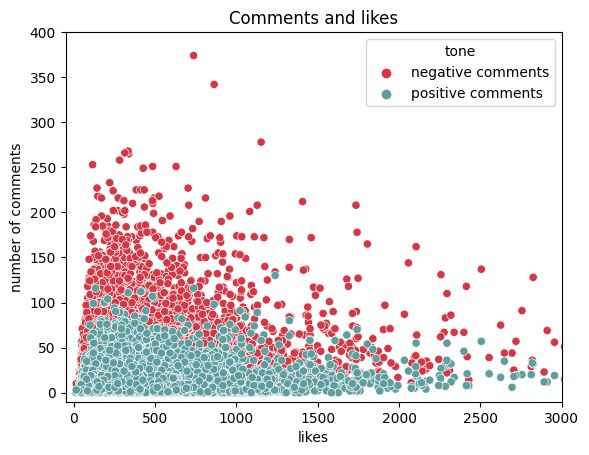

In [99]:
ax = sns.scatterplot(x='likes', y='number of comments', data=non_visible_df2,
                hue='tone', palette = ["#D33844", "#5F9E9F"])
ax.set_xlim(-50, 3000)
ax.set_ylim(-10, 400)
ax.set_title('Comments and likes')
plt.show()

-----
-----

В целом для любого количества лайков справедливо, что негативных комментариев больше, чем позитивных. Но нельзя сказать, что увеличение количества лайков способствует увеличению количества комментариев: больше похоже, что увеличение количества лайков снижает количество комментариев, причем как позитивных, так и негативных.

-----
-----

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [100]:
def beta_fn(a: pd.Series, b: pd.Series):
  part1 = a / (a + b)
  part2_num = a * b
  part2_denum = (np.square(a + b)) * (a + b + 1)
  part2 = np.sqrt(part2_num / part2_denum)
  return part1 - 1.65 * part2

In [101]:
df_comments_beta = df_comments.copy()
df_comments_beta.head()

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,positive_comments,negative_comments,neutral_comments
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,0,0,1
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,0,0,1
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261,1,0,0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,0,0,1
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,0,0,1


In [102]:
df_comments_beta_group_by_post = df_comments_beta.copy()
df_comments_beta_group_by_post = df_comments_beta_group_by_post[['post_id', 'positive_comments', 'negative_comments', 'neutral_comments']]
df_comments_beta_group_by_post = df_comments_beta_group_by_post.groupby(by='post_id').sum()
df_comments_beta_group_by_post['a'] = (1 + df_comments_beta_group_by_post['positive_comments'])
df_comments_beta_group_by_post['b'] = (1 + df_comments_beta_group_by_post['negative_comments'] + df_comments_beta_group_by_post['neutral_comments'])
df_comments_beta_group_by_post.head()

,positive_comments,negative_comments,neutral_comments,a,b
post_id,,,,,
18223951.0,9,56,166,10,223
18224542.0,1,14,69,2,84
18224684.0,2,12,30,3,43
18224973.0,6,7,24,7,32
18225324.0,12,54,183,13,238


In [103]:
df_vk_new2 = df_vk.copy()
df_vk_new2 = df_vk_new2.astype({'id':'int'})
df_vk_new2 = df_vk_new2[['id', 'title', 'target_tags']]
df_vk_new2 = df_vk_new2.set_index('id')
df_vk_new2.head()

,title,target_tags
id,,
24006362,"В ДНР заявили о задержании диверсантов, причас...",[в мире]
24006240,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",[происшествия]
24006100,"В Черном море нашли ""потерянный флот Гитлера""",[россия]
24005972,В США освободили задержанную российскую актрис...,"[в мире, сша, россия]"
24005764,Толкнувший Скабееву депутат Рады заявил о гроз...,"[в мире, украина]"


In [104]:
df_comments_and_vk2 = pd.concat([df_comments_beta_group_by_post, df_vk_new2], axis=1, join="inner")
df_comments_and_vk2.head()

,positive_comments,negative_comments,neutral_comments,a,b,title,target_tags
18223951.0,9,56,166,10,223,"Собчак заявила, что у нее нет политической про...","[россия, ксения собчак]"
18224542.0,1,14,69,2,84,"""Век программистов"" закончился, заявил Греф","[экономика, россия]"
18224684.0,2,12,30,3,43,"Кадыров показал стикеры, которые использует в ...",[общество]
18224973.0,6,7,24,7,32,Как российскую армию готовят к войнам будущего,[россия]
18225324.0,12,54,183,13,238,"КНДР заявила, что ""практически уравняла"" ядерн...","[в мире, кндр]"


In [105]:
df_comments_and_vk2['beta'] = beta_fn(df_comments_and_vk2['a'], df_comments_and_vk2['b'])
df_comments_and_vk2 = df_comments_and_vk2.sort_values(
    by=['beta'], ascending=False)
df_comments_and_vk2.head()

,positive_comments,negative_comments,neutral_comments,a,b,title,target_tags,beta
19965364.0,70,3,32,71,36,"Телескоп ""Хаббл"" сфотографировал сталкивающиес...",[россия],0.588533
21544373.0,69,10,39,70,50,Болельщики сборной России подарили Акинфееву б...,"[футбол, чемпионат мира по футболу 2018, спорт]",0.509382
19965584.0,112,8,80,113,89,Юлия Самойлова представит Россию на Евровидени...,"[культура, россия]",0.501912
21216757.0,36,2,23,37,26,Один из самых больших айсбергов на планете мож...,[],0.485761
21423423.0,79,15,58,80,74,Обратившаяся к Путину украинка встретилась с с...,[владимир путин],0.453265


In [106]:
df_comments_and_vk2_sorted = df_comments_and_vk2.copy()
df_comments_and_vk2_sorted = df_comments_and_vk2_sorted.sort_values(
    by=['beta'], ascending=False)
df_comments_and_vk2_sorted = df_comments_and_vk2_sorted[['title', 'target_tags', 'beta']]
df_comments_and_vk2_sorted.head(10)

,title,target_tags,beta
19965364.0,"Телескоп ""Хаббл"" сфотографировал сталкивающиес...",[россия],0.588533
21544373.0,Болельщики сборной России подарили Акинфееву б...,"[футбол, чемпионат мира по футболу 2018, спорт]",0.509382
19965584.0,Юлия Самойлова представит Россию на Евровидени...,"[культура, россия]",0.501912
21216757.0,Один из самых больших айсбергов на планете мож...,[],0.485761
21423423.0,Обратившаяся к Путину украинка встретилась с с...,[владимир путин],0.453265
19937112.0,Захарченко ответил на обвинения в причастности...,"[в мире, украина]",0.425475
19965898.0,Российские дзюдоисты победили в медальном заче...,"[единоборства, спорт]",0.421260
19965103.0,Украинские блогеры устроили перепалку из-за се...,"[ситуация на украине, украина]",0.405162
19960953.0,"Путин рассказал о ""захвате"" лайнера перед откр...",[сочи],0.399878
19699261.0,Ученые нашли на Багамах наследников вымершего ...,"[риа наука, открытия - риа наука]",0.377241


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__ можно увидеть, что в топ-10 входят новости о политике (4 новости), спорте и культуре (3 новости) и науке (3 новости). Соответственно, можно обучить нейросеть находить фамилию популярного политика, название спортивного турнира или отдельные слова, связанные с наукой ("телескоп", "планета", "ученые" и др.). Можно также сделать группировку по категориям и просуммировать показатель beta:

In [ ]:
df_variant = df_comments_and_vk2_sorted.copy()
df_variant = df_variant[['target_tags', 'beta']]
df_variant = df_variant.groupby(by='target_tags').sum()
df_variant.head()

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [120]:
df_comments_map = df_comments.copy()
df_comments_map = df_comments_map[df_comments_map['sentiment_verdict'] == 'negative']
df_comments_map = df_comments_map[['post_id', 'sentiment_score']]
df_comments_map.head()

577386

In [123]:
df_vk_new3 = df_vk.copy()
df_vk_new3 = df_vk_new3.astype({'id':'int'})
df_vk_new3 = df_vk_new3[['id', 'comments']]
df_vk_new3 = df_vk_new3.rename(columns={"id": "post_id"})
df_vk_new3.head()

,post_id,comments
0,24006362,28
1,24006240,42
2,24006100,23
3,24005972,35
4,24005764,145


In [126]:
df_comments_and_vk3 = df_comments_map.merge(df_vk_new3, on='post_id')
len(df_comments_and_vk3) == len(df_comments_map)

True

In [127]:
df_comments_and_vk3.head()

,post_id,sentiment_score,comments
0,24006362.0,0.791067,28
1,24006362.0,0.579184,28
2,24006362.0,0.899649,28
3,24006362.0,0.482806,28
4,24006362.0,0.899264,28


In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

new_X = np.array(df_comments_and_vk3['comments']).reshape(-1, 1)
new_y = np.array(df_comments_and_vk3['sentiment_score'])

reg = LinearRegression().fit(new_X, new_y)
new_preds = reg.predict(new_X)
print("Coefficients: \n", reg.coef_)
print("Mean squared error: %.2f" % mean_squared_error(new_y, new_preds))
print("Coefficient of determination: %.2f" % r2_score(new_y, new_preds))

Coefficients: 
 [-1.78964528e-07]
Mean squared error: 0.02
Coefficient of determination: 0.00


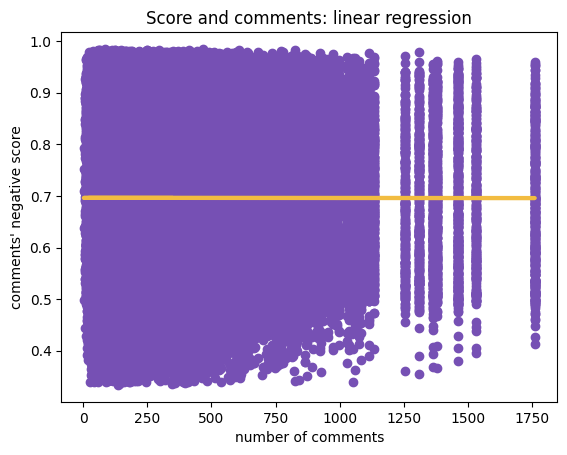

In [143]:
plt.scatter(new_X, new_y, color="#7650B4")
plt.xlabel("number of comments")
plt.ylabel("comments' negative score")
plt.title("Score and comments: linear regression")
plt.plot(new_X, new_preds, color="#F2BC41", linewidth=3)

-----
-----

Точно нельзя говорить о том, что температура комментария зависит от длины трэда

-----
-----